In [1]:
import os
import errno
import torch
import timeit
import imageio
import numpy as np
import torch.nn as nn
from adamW import AdamW
from torch.utils import data
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
from Loss import noisy_label_loss
from Utilis import segmentation_scores, CustomDataset_punet, calculate_cm
from Utilis import evaluate_noisy_label_3, evaluate_noisy_label_4, evaluate_noisy_label_5, evaluate_noisy_label_6
# our proposed model:
from Models import UNet_CMs
from PIL import Image

In [2]:
# ========================= #
# Hyper-parameters setting
# ========================= #

# hyper-parameters for model: 
input_dim = 3 # dimension of input
width = 36  #24 # width of the network
depth = 5 #3 # depth of the network, downsampling times is (depth-1)
class_no = 2 # class number, 2 for binary

# hyper-parameters for training:
train_batchsize = 16   #5 # batch size
alpha = 0.002 #0.001 # weight of the trace regularisation of learnt confusion matrices
num_epochs = 40 # total epochs
learning_rate = 1e-4 # learning rate     # 1e-2

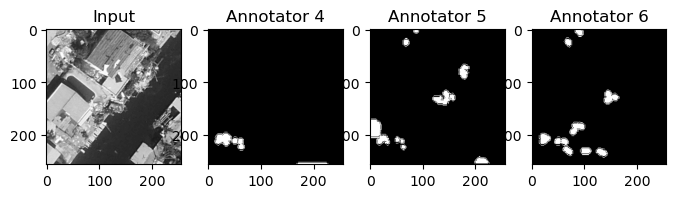

In [3]:
# ======================================= #
# Prepare a few data examples 
# ======================================= #

# Change path for your own datasets here:
data_path = './test_data_kooshan' ## TO BE MODIFIED
dataset_tag = 'test_kooshan' # Adjust this to your dataset tag
label_mode = 'multi'

# full path to train/validate/test:
test_path = data_path + '/test' 
train_path = data_path + '/train'
validate_path = data_path + '/validate'

# prepare data sets using our custom dataset
train_dataset = CustomDataset_punet(dataset_location=train_path, dataset_tag=dataset_tag, noisylabel=label_mode, augmentation=True)
validate_dataset = CustomDataset_punet(dataset_location=validate_path, dataset_tag=dataset_tag, noisylabel=label_mode, augmentation=False)
test_dataset = CustomDataset_punet(dataset_location=test_path, dataset_tag=dataset_tag, noisylabel=label_mode, augmentation=False)

# putting dataset into data loaders
trainloader = data.DataLoader(train_dataset, batch_size=train_batchsize, shuffle=True, num_workers=2, drop_last=True)
validateloader = data.DataLoader(validate_dataset, batch_size=1, shuffle=False, drop_last=False)
testloader = data.DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False)

# demonstrate the training samples:
Image_index_to_demonstrate = 6
images, label_1, label_2, label_3, imagename = validate_dataset[Image_index_to_demonstrate]
images = np.mean(images, axis=0)

# plot input image and the labels:
fig = plt.figure(figsize=(8, 10))
columns = 4
rows = 1
ax = []
labels = []
labels_names = []
labels.append(images)
labels.append(label_1)
labels.append(label_2)
labels.append(label_3)
labels_names.append('Input')
labels_names.append('Annotator 4')
labels_names.append('Annotator 5')
labels_names.append('Annotator 6')

for i in range(columns * rows):
    label_ = labels[i][0, :, :] if i != 0 else labels[i]
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title(labels_names[i]) 
    plt.imshow(label_, cmap='gray')
plt.show()

In [4]:
# ===== #
# Model
# ===== #

# call model:
model = UNet_CMs(in_ch=input_dim, width=width, depth=depth, class_no=class_no, norm='in', low_rank=False)

# model name for saving:
model_name = 'UNet_Confusion_Matrices_' + '_width' + str(width) + \
           '_depth' + str(depth) + '_train_batch_' + str(train_batchsize) + \
           '_alpha_' + str(alpha) + '_e' + str(num_epochs) + \
           '_lr' + str(learning_rate) 

# setting up device:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

UNet_CMs(
  (decoders): ModuleList(
    (0): Sequential(
      (0): Conv2d(72, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): PReLU(num_parameters=1)
      (3): Conv2d(36, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): InstanceNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (5): PReLU(num_parameters=1)
    )
    (1): Sequential(
      (0): Conv2d(144, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): PReLU(num_parameters=1)
      (3): Conv2d(36, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): InstanceNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (5): PReLU(num_parameters=1)
    )
    (2): Sequential(
      (0): C

In [5]:
# =================================================== #
# Prepare folders to save trained models and results 
# =================================================== #

# save location:
saved_information_path = './Results'
os.makedirs(saved_information_path, exist_ok=True)

saved_information_path = os.path.join(saved_information_path, model_name)
os.makedirs(saved_information_path, exist_ok=True)

saved_model_path = os.path.join(saved_information_path, 'trained_models')
os.makedirs(saved_model_path, exist_ok=True)

save_path_visual_result = os.path.join(saved_information_path, 'visual_results')
os.makedirs(save_path_visual_result, exist_ok=True)

# tensorboardX file saved location:
writer = SummaryWriter('./Results/Log_' + model_name)

In [6]:
# =================================================== #
# Training
# =================================================== #

# We use adamW optimiser for more accurate L2 regularisation
optimizer = AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)

for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0
    running_loss_ce = 0
    running_loss_trace = 0
    running_iou = 0
    
    for j, (images, label_1, label_2, label_3, imagename) in enumerate(trainloader):
        
        b, c, h, w = images.size()
        
        # zero gradients before each iteration
        optimizer.zero_grad()
        
        # cast numpy data into tensor float
        images = images.to(device=device, dtype=torch.float32)
        label_1 = label_1.to(device=device, dtype=torch.float32)
        label_2 = label_2.to(device=device, dtype=torch.float32)
        label_3 = label_3.to(device=device, dtype=torch.float32)
        
        labels_all = [label_1, label_2, label_3]
        
        # model has two outputs: 
        # first one is the probability map for true ground truth 
        # second one is a list collection of probability maps for different noisy ground truths
        outputs_logits, outputs_logits_noisy = model(images)
        
        # calculate loss:
        loss, loss_ce, loss_trace = noisy_label_loss(outputs_logits, outputs_logits_noisy, labels_all, alpha)

        # calculate the gradients:
        loss.backward()
        # update weights in model:
        optimizer.step()
        
        _, train_output = torch.max(outputs_logits, dim=1)
        train_iou = segmentation_scores(label_1.cpu().detach().numpy(), train_output.cpu().detach().numpy(), class_no)
        running_loss += loss
        running_loss_ce += loss_ce
        running_loss_trace += loss_trace
        running_iou += train_iou

        if (j + 1) == 1:
            # check the validation accuracy at the beginning of each epoch:
            v_dice, v_ged = evaluate_noisy_label_3(data=validateloader, model1=model, class_no=class_no)
            
            print(
                'Step [{}/{}], '
                'Val dice: {:.4f},'
                'Val GED: {:.4f},'
                'loss main: {:.4f},'
                'loss regularization: {:.4f},'.format(epoch + 1, num_epochs,
                                                            v_dice,
                                                            v_ged,
                                                            running_loss_ce / (j + 1),
                                                            running_loss_trace / (j + 1)))
        
            writer.add_scalars('scalars', {'loss': running_loss / (j + 1),
                                           'train iou': running_iou / (j + 1),
                                           'val iou': v_dice,
                                           'train main loss': running_loss_ce / (j + 1),
                                           'train regularization loss': running_loss_trace / (j + 1)}, epoch + 1)

# save model:
save_model_name_full = os.path.join(saved_model_path, model_name + '_Final.pt')
torch.save(model, save_model_name_full)
print('\n')
print('Training ended')

C:\Users\ka50\Box\Rice\Dr_Padgett\Projects\NSF Debris Modeling Project\Learn_Noisy_Labels\adamW.py:100: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\python_arg_parser.cpp:1581.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Step [1/40], Val dice: 0.4122,Val GED: 2.0487,loss main: 2.0321,loss regularization: 0.0057,
Step [2/40], Val dice: 0.3642,Val GED: 2.0175,loss main: 1.8886,loss regularization: 0.0057,
Step [3/40], Val dice: 0.3724,Val GED: 1.9950,loss main: 1.7217,loss regularization: 0.0057,
Step [4/40], Val dice: 0.3750,Val GED: 1.9925,loss main: 1.6009,loss regularization: 0.0058,
Step [5/40], Val dice: 0.3732,Val GED: 1.9993,loss main: 1.5455,loss regularization: 0.0058,
Step [6/40], Val dice: 0.3680,Val GED: 2.0029,loss main: 1.4984,loss regularization: 0.0058,
Step [7/40], Val dice: 0.3694,Val GED: 2.0010,loss main: 1.4563,loss regularization: 0.0058,
Step [8/40], Val dice: 0.3695,Val GED: 2.0059,loss main: 1.4276,loss regularization: 0.0058,
Step [9/40], Val dice: 0.3618,Val GED: 2.0078,loss main: 1.4143,loss regularization: 0.0058,
Step [10/40], Val dice: 0.3634,Val GED: 2.0120,loss main: 1.4125,loss regularization: 0.0057,
Step [11/40], Val dice: 0.3553,Val GED: 2.0102,loss main: 1.4087,loss

In [7]:
# =================================================== #
# Testing
# =================================================== #
model.eval()
for i, (v_images, label_1, label_2, label_3, imagename) in enumerate(testloader):
    v_images = v_images.to(device=device, dtype=torch.float32)
    v_outputs_logits_original, v_outputs_logits_noisy = model(v_images)
    b, c, h, w = v_outputs_logits_original.size()
    # plot the final segmentation map
    v_outputs_logits_original = nn.Softmax(dim=1)(v_outputs_logits_original)
    _, v_outputs_logits = torch.max(v_outputs_logits_original, dim=1)

    save_name = os.path.join(save_path_visual_result, 'test_' + str(i) + '_seg.png')
    save_name_label = os.path.join(save_path_visual_result, 'test_' + str(i) + '_label.png')
    save_name_slice = os.path.join(save_path_visual_result, 'test_' + str(i) + '_img.png')

    plt.imsave(save_name_slice, v_images[:, 1, :, :].reshape(h, w).cpu().detach().numpy(), cmap='gray')
    plt.imsave(save_name, v_outputs_logits.reshape(h, w).cpu().detach().numpy(), cmap='gray')
    plt.imsave(save_name_label, label_1.reshape(h, w).cpu().detach().numpy(), cmap='gray')
        
    # plot the noisy segmentation maps:
    v_outputs_logits_original = v_outputs_logits_original.reshape(b, c, h*w)
    v_outputs_logits_original = v_outputs_logits_original.permute(0, 2, 1).contiguous()
    v_outputs_logits_original = v_outputs_logits_original.view(b * h * w, c).view(b*h*w, c, 1)
    for j, cm in enumerate(v_outputs_logits_noisy):
        cm = cm.view(b, c**2, h*w).permute(0, 2, 1).contiguous().view(b*h*w, c*c).view(b*h*w, c, c)
        cm = cm / cm.sum(1, keepdim=True)
        v_noisy_output_original = torch.bmm(cm, v_outputs_logits_original).view(b*h*w, c)
        v_noisy_output_original = v_noisy_output_original.view(b, h*w, c).permute(0, 2, 1).contiguous().view(b, c, h, w)
        _, v_noisy_output = torch.max(v_noisy_output_original, dim=1)
        save_name = os.path.join(save_path_visual_result, 'test_' + str(i) + '_noisy_' + str(j) + '_seg.png')
        plt.imsave(save_name, v_noisy_output.reshape(h, w).cpu().detach().numpy(), cmap='gray')



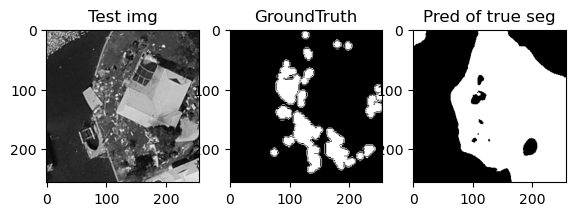

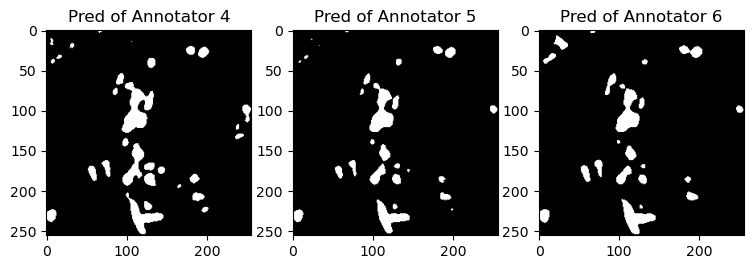

In [12]:
# =================================================== #
# Predictions Plot
# =================================================== #
test_data_index = 10

noisy_seg_1 = os.path.join(save_path_visual_result, 'test_' + str(test_data_index) + '_noisy_' + str(0) + '_seg.png')
noisy_seg_2 = os.path.join(save_path_visual_result, 'test_' + str(test_data_index) + '_noisy_' + str(1) + '_seg.png')
noisy_seg_3 = os.path.join(save_path_visual_result, 'test_' + str(test_data_index) + '_noisy_' + str(2) + '_seg.png')

seg = os.path.join(save_path_visual_result, 'test_' + str(test_data_index) + '_seg.png')
label = os.path.join(save_path_visual_result, 'test_' + str(test_data_index) + '_label.png')
img = os.path.join(save_path_visual_result, 'test_' + str(test_data_index) + '_img.png')

# plot image, ground truth and final segmentation
fig = plt.figure(figsize=(6.7, 13))
columns = 3
rows = 1

ax = []
imgs = [img, label, seg]
imgs_names = ['Test img', 'GroundTruth', 'Pred of true seg']

for i in range(columns*rows):
    img_ = imgs[i]
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title(imgs_names[i]) 
    img_ = Image.open(img_)
    img_ = np.array(img_, dtype='uint8')
    plt.imshow(img_, cmap='gray')
plt.show()

# plot the segmentation for noisy labels:
fig = plt.figure(figsize=(9, 13))
columns = 3
rows = 1

ax = []
noisy_segs = [noisy_seg_1, noisy_seg_2, noisy_seg_3]
noisy_segs_names = ['Pred of Annotator 4', 'Pred of Annotator 5', 'Pred of Annotator 6']

for i in range(columns*rows):
    noisy_seg_ = noisy_segs[i]
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title(noisy_segs_names[i]) 
    noisy_seg_ = Image.open(noisy_seg_)
    noisy_seg_ = np.array(noisy_seg_, dtype='uint8')
    plt.imshow(noisy_seg_, cmap='gray')
plt.show()